### Parker Dunn

## EK 381 - HW 10 - Optional Competition

### DUE: December 3rd, 2021

In [47]:
# Import Necessary Modules

import glob
import matplotlib.pyplot as plt 
from skimage import io
import numpy as np
%matplotlib inline

# Imports for TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD

# MY IMPORTS
import math

import json
from datetime import datetime
from datetime import date

### `read_data()` - copied from assignment to get the data into this script

In [48]:
#This function reads in all n images in catsfolder/ and dogsfolder/. 
#Each 64 x 64 image is reshaped into a length-4096 row vector. 
#These row vectors are stacked on top of one another to get a data matrix
#X of size n x 4096. We also generate a -1 label if the row vector corresponds
#to a cat image and a +1 label if the row vector corresponds to a dog image
#and stack these on top of one another to get a label vector y of length n.

def read_data():
    
    # get image filenames
    cat_locs = glob.glob('petdataset/catsfolder/*.jpg')
    dog_locs = glob.glob('petdataset/dogsfolder/*.jpg')
    num_cats = len(cat_locs)
    num_dogs = len(dog_locs)
    
    # initialize empty arrays
    X_cats = np.zeros((num_cats,64*64))
    X_dogs = np.zeros((num_dogs,64*64))
    y_cats = np.zeros((num_cats,1))
    y_dogs = np.zeros((num_dogs,1))
              
    #Load data, reshape into a 1D vector and set labels
    
    keep_track = 0

    for i in range(num_cats):
        img = cat_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_cats[i,:] = im
        y_cats[i] = -1.0
        keep_track += 1

    for i in range(num_dogs):
        img = dog_locs[i]
        im = io.imread(img)
        im = im.reshape(64*64)
        X_dogs[i,:] = im
        y_dogs[i] = 1.0
        keep_track += 1
    
    # combine both datasets
    X = np.append(X_cats,X_dogs,0)
    y = np.append(y_cats,y_dogs)
    
    return X, y

In [49]:
#This code implements the PCA exactly as in MATLAB so as to be consistent.
#It takes in an n x d data matrix X and returns a d x d orthonormal matrix pcaX. 
#Each column of pcaX contains a basis vector, sorted by decreasing variance.

def pca(X):
    covX = np.cov(X,rowvar=False)
    [Lambda,Vtranspose] = np.linalg.eig(covX)
    neworder = np.argsort(-abs(Lambda))
    pcaX = Vtranspose[:,neworder]
    pcaX = pcaX.real

    return pcaX

### `split_data()` - copied from assignment to create testing data

In [50]:
#This function takes in a data matrix X, label vector y, and 
#the desired percentage testpercent. It randomly assigns  
#testpercent of the rows of X and y to Xtest and ytest. 
#The remaining data is assigned to Xtrain and ytrain.

def split_data(X,y,testpercent):
        
    [n, d] = X.shape
    
    ntest = int(round(n*(float(testpercent)/100)))
    ntrain = int(round(n - ntest))
        
    Xtrain = np.zeros((ntrain,d))
    Xtest = np.zeros((ntest,d))
    ytrain = np.zeros((ntrain,1))
    ytest = np.zeros((ntest,1))   
        
    Data = np.column_stack((X,y))
    Data = np.random.permutation(Data)
    
    for i in range(ntest):
        Xtest[i,:] = Data[i,0:d]
        ytest[i] = Data[i,d]
        
    for i in range(ntrain):
        Xtrain[i,:] = Data[i+ntest,0:d]
        ytrain[i] = Data[i+ntest,d]
        
    return Xtrain, ytrain, Xtest, ytest

#### Using copied functions to prepare the data

In [51]:
# Read data from the image files
X, y = read_data()

# Splitting data into data for training and testing
Xtrain, ytrain, Xtest, ytest = split_data(X,y,20)
# 10% of the data reserved for testing

## `error_rate()` - copied from assignment for doing some assessment of manual testing

In [52]:
#This function takes in a vector of true labels ytrue
#and a vector of guessed labels yguess and reports back
#the error rate of the guesses as a percentage 0% to 100%.

def error_rate(ytrue, yguess):
    # compare your predictions with the correct labels to determine how many of your predictions were correct.
    total = len(ytrue)
    wrong = np.sum(np.not_equal(ytrue,yguess))
    error = 100*wrong/total
    # divide the number of correct predictions by the number of total samples to determine your classification accuracy.
    return error

## Developing a MLP Model with TensorFlow Keras API

Notes
* First part of the next step will be script for training the model
* A separate function for pet classification will be created


Problems:
* If I am goint to use PCA to modify the data before passing to the model, how do I provide the mu_train so that the function can center the data before passing to the model?


In [63]:
# I'm going to use PCA transform on the data for training and analysis!

# From above the available variables are:
# (1) Xtrain
# (2) ytrain
# (3) Xtest
# (4) ytest

# DATA PREP - will have to be repeated in the pet_classifier() function

k = 200

mu_train = np.mean(Xtrain, axis=0)
mu_test = np.mean(Xtest, axis=0)

Xtrain_cent = Xtrain - mu_train
Xtest_cent = Xtest - mu_train  # HMMMM how do I pass mu_train to the pet_classifier function?

pcaXtrain = pca(Xtrain)
Vk = pcaXtrain[0:k,:].T          # actual data can be rows, but Vk needs to be columns

Xtrain_reduced = Xtrain_cent @ Vk
Xtest_reduced = Xtest_cent @ Vk

for row in range(ytrain.shape[0]):
    if (ytrain[row,0] == -1):
        ytrain[row,0] = 0
    # else:
    #     ytrain[row,0] = 1

print(ytrain[0:10,0])

for row in range(ytest.shape[0]):
    if (ytest[row,0] == -1):
        ytest[row,0] = 0
    # else:
    #     ytrain[row,0] = 1

print("shape of Xtrain_reduced: {}".format(Xtrain_reduced.shape))
print("shape of Xtest_reduced: {}".format(Xtest_reduced.shape))
print("Shapes of y vectors: {} , {}".format(ytrain.shape, ytest.shape))

# DEFINING, COMPILING, FITTING, AND EVALUATING THE MODEL

# num_features = Xtrain.shape[1]

model = Sequential()
# NOTE: number of features should always be k
model.add(Dense(40, activation='relu', kernel_initializer='he_normal', input_shape=(k,)))
model.add(Dense(20, activation='relu', kernel_initializer='he_normal'))
# model.add(Dropout(0.5))
model.add(Dense(10, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(5, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(learning_rate=0.00001, momentum=0.8)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

# Made some random choices at this staage in particular:
# epochs - (1) 100

# batch_size - (1) 200

history = model.fit(Xtrain_reduced, ytrain, epochs=50, batch_size=200, verbose=0, validation_split=0.2)
# model.fit(Xtrain, ytrain, epochs=100, batch_size=200, verbose=2)

loss, accuracy = model.evaluate(Xtest_reduced, ytest, verbose=0)
# loss, accuracy = model.evaluate(Xtest, ytest, verbose=2)

print("Test Accuracy: %.3f\n\n" % accuracy)

# display a summary of the model
model.summary()
# plot_model(model, 'model.png', show_shapes = True)

print("\n\n")

[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
shape of Xtrain_reduced: (1600, 200)
shape of Xtest_reduced: (400, 200)
Shapes of y vectors: (1600, 1) , (400, 1)
Test Accuracy: 0.777


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 40)                8040      
_________________________________________________________________
dense_47 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_48 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_49 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 6         
Total params: 9,131
Trainable params: 9,131
Non-trainable params: 0
______________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


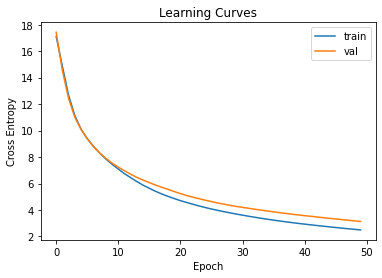

In [64]:
# PLOTTING THE MODEL
print(history.history.keys())

plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy")
plt.plot(history.history['loss'], label = "train")
plt.plot(history.history['val_loss'], label = 'val')
plt.legend()
plt.show()

### Using the model and testing it on other data

In [65]:
# GETTING DATA SOME STRUCTURES PREPARED

# From above we have a small amount of testing data available
# (1) Xtest
# (2) ytest

# create "yguess" for the testing data
# yguess = np.zeros(ytest.shape[0])
# print("Shape of ytest is {}".format(ytest.shape))

yhat = model.predict(Xtest_reduced)
yhat2 = np.array([np.zeros(yhat.shape[0])]).T
print("Shape of yhat2 is {}".format(yhat2.shape))

for j in range(yhat.shape[0]):
    if (yhat[j,0] >= 0.5):
        yhat2[j,0] = 1.0
    else:
        yhat2[j,0] = 0.0

print("Shape of yhat is {}".format(yhat.shape))
print("Shape of ytest is {}".format(ytest.shape))

print("Guess\tActual")
for i in range(10):
    print("{:.2f}\t{:.2f}".format(yhat2[i,0], ytest[i,0]))

error = error_rate(ytest, yhat2)
print("Error rate was {:.2f}".format(error))

Shape of yhat2 is (400, 1)
Shape of yhat is (400, 1)
Shape of ytest is (400, 1)
Guess	Actual
0.00	0.00
0.00	1.00
0.00	1.00
0.00	1.00
1.00	1.00
1.00	0.00
1.00	1.00
0.00	1.00
1.00	1.00
1.00	0.00
Error rate was 22.25


## THINGS THAT NEED TO BE SAVED AND LOADED IN A NEW SCRIPT

* The model
* Vk - for transforming data
* mu_vector - a vector containing the average image ... for transforming the data
* a testing row --> Xtrain[381,:]

In [72]:
print(Xtrain[381,:])
print(Xtrain[381,:].shape)

# for n in range(4096):
#     print("{}, ".format(Xtrain[381,n]))

mu = np.mean(X, axis=0)
print(mu.shape)
print(Vk.shape)

[170. 176. 166. ... 105. 101. 103.]
(4096,)
(4096,)
(4096, 200)


In [74]:
model.save("petclassifier.h5")

with open('eigmat.npy', 'wb') as eigenvecs:
    np.save(eigenvecs, Vk)

with open('xsample.npy', 'wb') as xdemo:
    np.save(xdemo, Xtrain[381,:])

with open('muX.npy', 'wb') as avg:
    np.save(avg, mu)